# Translation of Numeric Phrases with Seq2Seq

In the following we will try to build a **translation model from french phrases describing numbers** to the corresponding **numeric representation** (base 10).

This is a toy machine translation task with a **restricted vocabulary** and a **single valid translation for each source phrase** which makes it more tractable to train on a laptop computer and easier to evaluate. Despite those limitations we expect that this task will highlight interesting properties of Seq2Seq models including:

- the ability to **deal with different length** of the source and target sequences,
- handling token with a **meaning that changes depending on the context** (e.g "quatre" vs "quatre vingts" in "quatre cents"),
- basic counting and "reasoning" capabilities of LSTM and GRU models.

The parallel text data is generated from a "ground-truth" Python function named `to_french_phrase` that captures common rules. Hyphenation was intentionally omitted to make the phrases more ambiguous and therefore make the translation problem slightly harder to solve (and also because Olivier had no particular interest hyphenation in properly implementing rules :).

In [1]:
from french_numbers import to_french_phrase

for x in [21, 80, 81, 300, 213, 1100, 1201, 301000, 80080]:
    print(str(x).rjust(6), to_french_phrase(x))

    21 vingt et un
    80 quatre vingts
    81 quatre vingt un
   300 trois cents
   213 deux cent treize
  1100 mille cent
  1201 mille deux cent un
301000 trois cent un mille
 80080 quatre vingt mille quatre vingts


## Generating a Training Set

The following will **generate phrases 20000 example phrases for numbers between 1 and 1,000,000** (excluded). We chose to over-represent small numbers by generating all the possible short sequences between 1 and `exhaustive`.

We then split the generated set into non-overlapping train, validation and test splits.

In [2]:
from french_numbers import generate_translations
from sklearn.model_selection import train_test_split


numbers, french_numbers = generate_translations(
    low=1, high=int(1e6) - 1, exhaustive=5000, random_seed=0)
num_train, num_dev, fr_train, fr_dev = train_test_split(
    numbers, french_numbers, test_size=0.5, random_state=0)

num_val, num_test, fr_val, fr_test = train_test_split(
    num_dev, fr_dev, test_size=0.5, random_state=0)

In [3]:
len(fr_train), len(fr_val), len(fr_test)

(10000, 5000, 5000)

In [4]:
for i, fr_phrase, num_phrase in zip(range(5), fr_train, num_train):
    print(num_phrase.rjust(6), fr_phrase)

  2882 deux mille huit cent quatre vingt deux
372200 trois cent soixante douze mille deux cents
  2193 deux mille cent quatre vingt treize
996418 neuf cent quatre vingt seize mille quatre cent dix huit
  9172 neuf mille cent soixante douze


In [5]:
for i, fr_phrase, num_phrase in zip(range(5), fr_val, num_val):
    print(num_phrase.rjust(6), fr_phrase)

  2804 deux mille huit cent quatre
  3898 trois mille huit cent quatre vingt dix huit
 82996 quatre vingt deux mille neuf cent quatre vingt seize
366346 trois cent soixante six mille trois cent quarante six
 56006 cinquante six mille six


## Vocabularies

Build the vocabularies from the training set only to get a chance to have some out-of-vocabulary words in the validation and test sets.

First we need to introduce specific symbols that will be used to:
- pad sequences
- mark the beginning of translation
- mark the end of translation
- be used as a placehold for out-of-vocabulary symbols (not seen in the training set).

Here we use the same convention as the [tensorflow seq2seq tutorial](https://www.tensorflow.org/tutorials/seq2seq):

In [6]:
PAD, GO, EOS, UNK = START_VOCAB = ['_PAD', '_GO', '_EOS', '_UNK']

To build the vocabulary we need to tokenize the sequences of symbols. For the digital number representation we use character level tokenization while whitespace-based word level tokenization will do for the French phrases:

In [7]:
def tokenize(sentence, word_level=True):
    if word_level:
        return sentence.split()
    else:
        return [sentence[i:i + 1] for i in range(len(sentence))]

In [8]:
tokenize('1234', word_level=False)

['1', '2', '3', '4']

In [9]:
tokenize('mille deux cent trente quatre', word_level=True)

['mille', 'deux', 'cent', 'trente', 'quatre']

Let's now use this tokenization strategy to assign a unique integer token id to each possible token string found the traing set in each language ('French' and 'numeric'): 

In [10]:
def build_vocabulary(tokenized_sequences):
    rev_vocabulary = START_VOCAB[:]
    unique_tokens = set()
    for tokens in tokenized_sequences:
        unique_tokens.update(tokens)
    rev_vocabulary += sorted(unique_tokens)
    vocabulary = {}
    for i, token in enumerate(rev_vocabulary):
        vocabulary[token] = i
    return vocabulary, rev_vocabulary

In [11]:
tokenized_fr_train = [tokenize(s, word_level=True) for s in fr_train]
tokenized_num_train = [tokenize(s, word_level=False) for s in num_train]

fr_vocab, rev_fr_vocab = build_vocabulary(tokenized_fr_train)
num_vocab, rev_num_vocab = build_vocabulary(tokenized_num_train)

The two languages do not have the same vocabulary sizes:

In [12]:
len(fr_vocab)

30

In [13]:
len(num_vocab)

14

In [14]:
for k, v in sorted(fr_vocab.items())[:10]:
    print(k.rjust(10), v)
print('...')

      _EOS 2
       _GO 1
      _PAD 0
      _UNK 3
      cent 4
     cents 5
      cinq 6
 cinquante 7
      deux 8
       dix 9
...


In [15]:
for k, v in sorted(num_vocab.items()):
    print(k.rjust(10), v)

         0 4
         1 5
         2 6
         3 7
         4 8
         5 9
         6 10
         7 11
         8 12
         9 13
      _EOS 2
       _GO 1
      _PAD 0
      _UNK 3


We also built the reverse mappings from token ids to token string representations:

In [16]:
print(rev_fr_vocab)

['_PAD', '_GO', '_EOS', '_UNK', 'cent', 'cents', 'cinq', 'cinquante', 'deux', 'dix', 'douze', 'et', 'huit', 'mille', 'neuf', 'onze', 'quarante', 'quatorze', 'quatre', 'quinze', 'seize', 'sept', 'six', 'soixante', 'treize', 'trente', 'trois', 'un', 'vingt', 'vingts']


In [17]:
print(rev_num_vocab)

['_PAD', '_GO', '_EOS', '_UNK', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


## Seq2Seq with a single GRU architecture

<img src="images/basic_seq2seq.png" width="80%" />

From: [Sutskever, Ilya, Oriol Vinyals, and Quoc V. Le. "Sequence to sequence learning with neural networks." NIPS 2014](https://arxiv.org/abs/1409.3215)



For a given source sequence - target sequence pair, we will:
- tokenize the source and target sequences;
- reverse the order of the source sequence;
- build the input sequence by concatenating the reversed source sequence and the target sequence in original order using the `_GO` token as a delimiter, 
- build the output sequence by appending the `_EOS` token to the source sequence.


Let's do this as a function using the original string representations for the tokens so as to make it easier to debug:

**Exercise**
- Build a function which adapts a pair of tokenized sequences to the framework above.
- The function should have a reverse_source as an option.

*Note*: 
- The function should output two sequences of string tokens: one to be fed as the input and the other as expected output for the seq2seq network. We will handle the padding later;
- Don't forget to insert the `_GO` and `_EOS` special symbols at the right locations.

In [18]:
# %load solutions/make_input_output.py
def make_input_output(source_tokens, target_tokens, reverse_source=True):
    if reverse_source:
        source_tokens = source_tokens[::-1]
    input_tokens = source_tokens + [GO] + target_tokens
    output_tokens = target_tokens + [EOS]
    return input_tokens, output_tokens


In [19]:
input_tokens, output_tokens = make_input_output(
    ['cent', 'vingt', 'et', 'un'],
    ['1', '2', '1'],
)

In [20]:
input_tokens

['un', 'et', 'vingt', 'cent', '_GO', '1', '2', '1']

In [21]:
output_tokens

['1', '2', '1', '_EOS']

### Vectorization of the parallel corpus

Let's apply the previous transformation to each pair of (source, target) sequene and use a shared vocabulary to store the results in numpy arrays of integer token ids, with padding on the left so that all input / output sequences have the same length: 

In [22]:
all_tokenized_sequences = tokenized_fr_train + tokenized_num_train
shared_vocab, rev_shared_vocab = build_vocabulary(all_tokenized_sequences)

In [23]:
import numpy as np
max_length = 20  # found by introspection of our training set

def vectorize_corpus(source_sequences, target_sequences, shared_vocab,
                     word_level_source=True, word_level_target=True,
                     max_length=max_length):
    assert len(source_sequences) == len(target_sequences)
    n_sequences = len(source_sequences)
    source_ids = np.empty(shape=(n_sequences, max_length), dtype=np.int32)
    source_ids.fill(shared_vocab[PAD])
    target_ids = np.empty(shape=(n_sequences, max_length), dtype=np.int32)
    target_ids.fill(shared_vocab[PAD])
    numbered_pairs = zip(range(n_sequences), source_sequences, target_sequences)
    for i, source_seq, target_seq in numbered_pairs:
        source_tokens = tokenize(source_seq, word_level=word_level_source)
        target_tokens = tokenize(target_seq, word_level=word_level_target)
        
        in_tokens, out_tokens = make_input_output(source_tokens, target_tokens)
        
        in_token_ids = [shared_vocab.get(t, UNK) for t in in_tokens]
        source_ids[i, -len(in_token_ids):] = in_token_ids
    
        out_token_ids = [shared_vocab.get(t, UNK) for t in out_tokens]
        target_ids[i, -len(out_token_ids):] = out_token_ids
    return source_ids, target_ids

In [24]:
X_train, Y_train = vectorize_corpus(fr_train, num_train, shared_vocab,
                                    word_level_target=False)

In [25]:
X_train.shape

(10000, 20)

In [26]:
Y_train.shape

(10000, 20)

In [27]:
fr_train[0]

'deux mille huit cent quatre vingt deux'

In [28]:
num_train[0]

'2882'

In [29]:
X_train[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0, 18, 38, 28, 14, 22, 23, 18,  1,  6,
       12, 12,  6], dtype=int32)

In [30]:
Y_train[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6, 12,
       12,  6,  2], dtype=int32)

This looks good. In particular we can note:

- the PAD=0 symbol at the beginning of the two sequences,
- the input sequence has the GO=1 symbol to separate the source from the target,
- the output sequence is a shifted version of the target and ends with EOS=2.

Let's vectorize the validation and test set to be able to evaluate our models:

In [31]:
X_val, Y_val = vectorize_corpus(fr_val, num_val, shared_vocab,
                                word_level_target=False)
X_test, Y_test = vectorize_corpus(fr_test, num_test, shared_vocab,
                                  word_level_target=False)

In [32]:
X_val.shape, Y_val.shape

((5000, 20), (5000, 20))

In [33]:
X_test.shape, Y_test.shape

((5000, 20), (5000, 20))

### A simple homogeneous Seq2Seq architecture

To keep the architecture simple we will use the **same RNN model and weights for both the encoder part** (before the `_GO` token) **and the decoder part** (after the `_GO` token).

We may GRU recurrent cell instead of LSTM because it is slightly faster to compute and should give comparable results.

**Exercise:**
- Build a Seq2Seq model:
  - Start with an Embedding layer;
  - Add a single GRU layer: the GRU layer should yield a sequence of output vectors, one at each timestep;
  - Add a Dense layer to adapt the ouput dimension of the GRU layer to the dimension of the output vocabulary;
  - Don't forget to insert some Dropout layer(s), especially after the Embedding layer.

Note:
- The output dimension of the Embedding layer should be smaller than usual be cause we have small vocabulary size;
- The dimension of the GRU should be larger to give the Seq2Seq model enough "working memory" to memorize the full input sequence before decoding it;
- Your model should output a shape `[batch, sequence_length, vocab_size]`.

In [34]:
# %load solutions/simple_seq2seq.py
from keras.models import Sequential
from keras.layers import Embedding, Dropout, GRU, Dense

vocab_size = len(shared_vocab)
simple_seq2seq = Sequential()
simple_seq2seq.add(Embedding(vocab_size, 32, input_length=max_length))
simple_seq2seq.add(Dropout(0.2))
simple_seq2seq.add(GRU(256, return_sequences=True))
simple_seq2seq.add(Dense(vocab_size, activation='softmax'))

# Here we use the sparse_categorical_crossentropy loss to be able to pass
# integer-coded output for the token ids without having to convert to one-hot
# codes
simple_seq2seq.compile(optimizer='adam', loss='sparse_categorical_crossentropy')


Using TensorFlow backend.


Let's use a callback mechanism to automatically snapshot the best model found so far on the validation set:

In [37]:
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


best_model_fname = "simple_seq2seq_checkpoint.h5"
best_model_cb = ModelCheckpoint(best_model_fname, monitor='val_loss',
                                save_best_only=True, verbose=1)

We need to use np.expand_dims trick on Y: this is required by Keras because of we use a sparse (integer-based) representation for the output:

/Users/ruizhang/anaconda3/anaconda/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 10000 samples, validate on 5000 samples
Epoch 1/5
Epoch 00000: val_loss improved from inf to 0.59540, saving model to simple_seq2seq_checkpoint.h5
37s - loss: 0.5978 - val_loss: 0.5954
Epoch 2/5
Epoch 00001: val_loss improved from 0.59540 to 0.53894, saving model to simple_seq2seq_checkpoint.h5
30s - loss: 0.5624 - val_loss: 0.5389
Epoch 3/5
Epoch 00002: val_loss improved from 0.53894 to 0.50968, saving model to simple_seq2seq_checkpoint.h5
32s - loss: 0.5385 - val_loss: 0.5097
Epoch 4/5
Epoch 00003: val_loss improved from 0.50968 to 0.44260, saving model to simple_seq2seq_checkpoint.h5
37s - loss: 0.5239 - val_loss: 0.4426
Epoch 5/5
Epoch 00004: val_loss did not improve
35s - loss: 0.4084 - val_loss: 0.5611


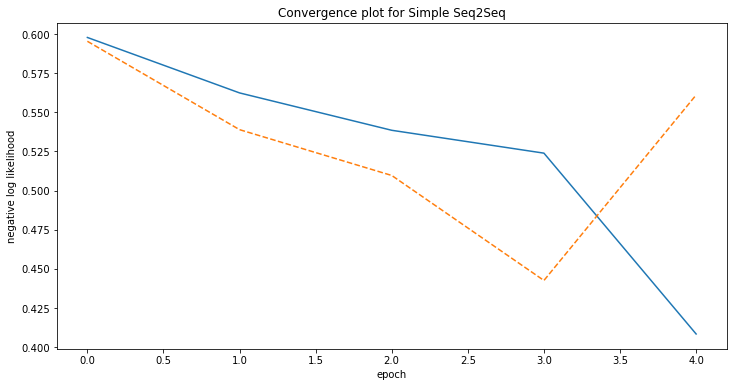

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

history = simple_seq2seq.fit(X_train, np.expand_dims(Y_train, -1),
                             validation_data=(X_val, np.expand_dims(Y_val, -1)),
                             nb_epoch=5, verbose=2, batch_size=32,
                             callbacks=[best_model_cb])

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], '--', label='validation')
plt.ylabel('negative log likelihood')
plt.xlabel('epoch')
plt.title('Convergence plot for Simple Seq2Seq')

Let's load the best model found on the validation set at the end of training:

In [41]:
weights = simple_seq2seq.get_weights()
print([w.shape for w in weights])

simple_seq2seq.summary()

[(40, 32), (32, 768), (256, 768), (768,), (256, 40), (40,)]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 32)            1280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 32)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 20, 256)           221952    
_________________________________________________________________
dense_1 (Dense)              (None, 20, 40)            10280     
Total params: 233,512
Trainable params: 233,512
Non-trainable params: 0
_________________________________________________________________


In [39]:
simple_seq2seq = load_model(best_model_fname)

If you don't have access to a GPU and cannot wait 10 minutes to for the model to converge to a reasonably good state, feel to use the pretrained model. This model has been obtained by training the above model for ~150 epochs. The validation loss is significantly lower than 1e-5. In practice it should hardly ever make any prediction error on this easy translation problem.

Alternatively we will load this imperfect model (trained only to 50 epochs) with a validation loss of ~7e-4. This model makes funny translation errors so I would suggest to try it first:

In [40]:
from keras.utils.data_utils import get_file
import os

get_file("simple_seq2seq_partially_pretrained.h5", 
         "https://github.com/m2dsupsdlclass/lectures-labs/releases/"
         "download/0.4/simple_seq2seq_partially_pretrained.h5")

filename = os.path.expanduser(os.path.join('~', 
                                           '.keras/datasets/simple_seq2seq_partially_pretrained.h5'))

### Uncomment the following to replace for the fully trained network 

#get_file("simple_seq2seq_pretrained.h5", 
#         "https://github.com/m2dsupsdlclass/lectures-labs/releases/"
#         "download/0.4/simple_seq2seq_pretrained.h5")
#filename = os.path.expanduser(os.path.join('~', 
#                                           '.keras/datasets/simple_seq2seq_pretrained.h5'))

simple_seq2seq = load_model(filename)

/Users/ruizhang/anaconda3/anaconda/lib/python3.6/site-packages/keras/engine/topology.py:1242: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  return cls(**config)
/Users/ruizhang/anaconda3/anaconda/lib/python3.6/site-packages/keras/engine/topology.py:1242: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(input_dim=40, activity_regularizer=None, output_dim=32, mask_zero=False, input_dtype="int32", name="embedding_1", input_length=20, trainable=True, batch_input_shape=[None, 20], embeddings_initializer="uniform", embeddings_regularizer=None, embeddings_constraint=None)`
  return cls(**config)
/Users/ruizhang/anaconda3/anaconda/lib/python3.6/site-packages/keras/engine/topology.py:1242: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(trainable=True, name="dropout_1", rate=0.2)`
  return cls(**config)
/Users

ValueError: Optimizer weight shape (40,) not compatible with provided weight shape (256, 40)

Let's have a look at a raw prediction on the first sample of the test set:

In [ ]:
fr_test[0]

In numeric array this is provided (along with the expected target sequence) as the following padded input sequence:

In [ ]:
first_test_sequence = X_test[0:1]
first_test_sequence

Remember that the `_GO` (symbol indexed at `1`) separates the reversed source from the expected target sequence:  

In [ ]:
rev_shared_vocab[1]

### Interpreting the model prediction

**Exercise **:
- Feed this test sequence into the model. What is the shape of the output?
- Get the argmax of each output prediction to get the most likely symbols
- Dismiss the padding / end of sentence
- Convert to readable vocabulary using rev_shared_vocab

*Interpretation*
- Compare the output with the first example in numerical format `num_test[0]`
- What do you think of this way of decoding? Is it correct to use it at inference time?

In [ ]:
# %load solutions/interpret_output.py
prediction = simple_seq2seq.predict(first_test_sequence)
print("prediction shape:", prediction.shape)

# Let's use `argmax` to extract the predicted token ids at each step:
predicted_token_ids = prediction[0].argmax(-1)
print("prediction token ids:", predicted_token_ids)

# We can use the shared reverse vocabulary to map 
# this back to the string representation of the tokens,
# as well as removing Padding and EOS symbols
predicted_numbers = [rev_shared_vocab[token_id] for token_id in predicted_token_ids
                     if token_id not in (shared_vocab[PAD], shared_vocab[EOS])]
print("predicted number:", "".join(predicted_numbers))
print("test number:", num_test[0])

# The model successfully predicted the test sequence.
# However, we provided the full sequence as input, including all the solution
# (except for the last number). In a real testing condition, one wouldn't
# have the full input sequence, but only what is provided before the "GO"
# symbol


In the previous exercise we cheated a bit because we gave the complete sequence along with the solution in the input sequence. To correctly predict we need to predict one token at a time and reinject the predicted token in the input sequence to predict the next token:

In [ ]:
def greedy_translate(model, source_sequence, shared_vocab, rev_shared_vocab,
                     word_level_source=True, word_level_target=True):
    """Greedy decoder recursively predicting one token at a time"""
    # Initialize the list of input token ids with the source sequence
    source_tokens = tokenize(source_sequence, word_level=word_level_source)
    input_ids = [shared_vocab.get(t, UNK) for t in source_tokens[::-1]]
    input_ids += [shared_vocab[GO]]

    # Prepare a fixed size numpy array that matches the expected input
    # shape for the model
    input_array = np.empty(shape=(1, model.input_shape[1]),
                           dtype=np.int32)
    decoded_tokens = []
    while len(input_ids) <= max_length:
        # Vectorize a the list of input tokens as 
        # and use zeros padding.
        input_array.fill(shared_vocab[PAD])
        input_array[0, -len(input_ids):] = input_ids
        
        # Predict the next output: greedy decoding with argmax
        next_token_id = model.predict(input_array)[0, -1].argmax()
        
        # Stop decoding if the network predicts end of sentence:
        if next_token_id == shared_vocab[EOS]:
            break
            
        # Otherwise use the reverse vocabulary to map the prediction
        # back to the string space
        decoded_tokens.append(rev_shared_vocab[next_token_id])
        
        # Append prediction to input sequence to predict the next
        input_ids.append(next_token_id)

    separator = " " if word_level_target else ""
    return separator.join(decoded_tokens)

In [ ]:
phrases = [
    "un",
    "deux",
    "trois",
    "onze",
    "quinze",
    "cent trente deux",
    "cent mille douze",
    "sept mille huit cent cinquante neuf",
    "vingt et un",
    "vingt quatre",
    "quatre vingts",
    "quatre vingt onze mille",
    "quatre vingt onze mille deux cent deux",
]
for phrase in phrases:
    translation = greedy_translate(simple_seq2seq, phrase,
                                   shared_vocab, rev_shared_vocab,
                                   word_level_target=False)
    print(phrase.ljust(40), translation)

Why does the partially trained network is able to correctly give the output for

`"sept mille huit cent cinquante neuf"`

but not for:

`"cent mille douze"` ?

The answer is as following:
- it is rather easy for the network to learn a correspondance between symbols (first case), by dismissing `"cent"` and `"mille"`
- outputing the right amount of symbols, especially `0s` for `"cent mille douze"` requires more reasoning and ability to count.

In [ ]:
phrases = [
    "quatre vingt et un",
    "quarante douze",
    "onze cent soixante vingt quatorze",
]
for phrase in phrases:
    translation = greedy_translate(simple_seq2seq, phrase,
                                   shared_vocab, rev_shared_vocab,
                                   word_level_target=False)
    print(phrase.ljust(40), translation)

## Model evaluation

Because **we expect only one correct translation** for a given source sequence, we can use **phrase-level accuracy** as a metric to quantify our model quality.

Note that **this is not the case for real translation models** (e.g. from French to English on arbitrary sentences). Evaluation of a machine translation model is tricky in general. Automated evaluation can somehow be done at the corpus level with the [BLEU score](https://en.wikipedia.org/wiki/BLEU) (bilingual evaluation understudy) given a large enough sample of correct translations provided by certified translators but its only a noisy proxy.

The only good evaluation is to give a large enough sample of the model predictions on some test sentences to certified translators and ask them to give an evaluation (e.g. a score between 0 and 6, 0 for non-sensical and 6 for the hypothetical perfect translation). However in practice this is very costly to do.

Fortunately we can just use phrase-level accuracy on a our very domain specific toy problem:

In [ ]:
def phrase_accuracy(model, num_sequences, fr_sequences, n_samples=300,
                    decoder_func=greedy_translate):
    correct = []
    n_samples = len(num_sequences) if n_samples is None else n_samples
    for i, num_seq, fr_seq in zip(range(n_samples), num_sequences, fr_sequences):
        if i % 100 == 0:
            print("Decoding %d/%d" % (i, n_samples))

        predicted_seq = decoder_func(simple_seq2seq, fr_seq,
                                     shared_vocab, rev_shared_vocab,
                                     word_level_target=False)
        correct.append(num_seq == predicted_seq)
    return np.mean(correct)

In [ ]:
print("Phrase-level test accuracy: %0.3f"
      % phrase_accuracy(simple_seq2seq, num_test, fr_test))

In [ ]:
print("Phrase-level train accuracy: %0.3f"
      % phrase_accuracy(simple_seq2seq, num_train, fr_train))

## Bonus: Decoding with a Beam Search

Instead of decoding with greedy strategy that only considers the most-likely next token at each prediction, we can hold a priority queue of the most promising top-n sequences ordered by loglikelihoods.

This could potentially improve the final accuracy of an imperfect model: indeed it can be the case that the most likely sequence (based on the conditional proability estimated by the model) starts with a character that is not the most likely alone.

**Bonus Exercise:**
- build a beam_translate function which decodes candidate translations with a beam search strategy
- use a list of candidates, tracking `beam_size` candidates and their corresponding likelihood
- compute predictions for the next outputs by using predict with a batch of the size of the beam
- be careful to stop appending results if EOS symbols have been found for each candidate!

In [ ]:
def beam_translate(model, source_sequence, shared_vocab, rev_shared_vocab,
                   word_level_source=True, word_level_target=True,
                   beam_size=10, return_ll=False):
    """Decode candidate translations with a beam search strategy
    
    If return_ll is False, only the best candidate string is returned.
    If return_ll is True, all the candidate strings and their loglikelihoods
    are returned.
    """

In [ ]:
# %load solutions/beam_search.py
def beam_translate(model, source_sequence, shared_vocab, rev_shared_vocab,
                   word_level_source=True, word_level_target=True,
                   beam_size=10, return_ll=False):
    """Decode candidate translations with a beam search strategy
    
    If return_ll is False, only the best candidate string is returned.
    If return_ll is True, all the candidate strings and their loglikelihoods
    are returned.
    """
    # Initialize the list of input token ids with the source sequence
    source_tokens = tokenize(source_sequence, word_level=word_level_source)
    input_ids = [shared_vocab.get(t, UNK) for t in source_tokens[::-1]]
    input_ids += [shared_vocab[GO]]
    
    # initialize loglikelihood, input token ids, decoded tokens for
    # each candidate in the beam
    candidates = [(0, input_ids[:], [], False)]

    # Prepare a fixed size numpy array that matches the expected input
    # shape for the model
    input_array = np.empty(shape=(beam_size, model.input_shape[1]),
                           dtype=np.int32)
    while any([not done and (len(input_ids) < max_length)
               for _, input_ids, _, done in candidates]):
        # Vectorize a the list of input tokens and use zeros padding.
        input_array.fill(shared_vocab[PAD])
        for i, (_, input_ids, _, done) in enumerate(candidates):
            if not done:
                input_array[i, -len(input_ids):] = input_ids
        
        # Predict the next output in a single call to the model to amortize
        # the overhead and benefit from vector data parallelism on GPU.
        next_likelihood_batch = model.predict(input_array)
        
        # Build the new candidates list by summing the loglikelood of the
        # next token with their parents for each new possible expansion.
        new_candidates = []
        for i, (ll, input_ids, decoded, done) in enumerate(candidates):
            if done:
                new_candidates.append((ll, input_ids, decoded, done))
            else:
                next_loglikelihoods = np.log(next_likelihood_batch[i, -1])
                for next_token_id, next_ll in enumerate(next_loglikelihoods):
                    new_ll = ll + next_ll
                    new_input_ids = input_ids[:]
                    new_input_ids.append(next_token_id)
                    new_decoded = decoded[:]
                    new_done = done
                    if next_token_id == shared_vocab[EOS]:
                        new_done = True
                    if not new_done:
                        new_decoded.append(rev_shared_vocab[next_token_id])
                    new_candidates.append(
                        (new_ll, new_input_ids, new_decoded, new_done))
        
        # Only keep a beam of the most promising candidates
        new_candidates.sort(reverse=True)
        candidates = new_candidates[:beam_size]

    separator = " " if word_level_target else ""
    if return_ll:
        return [(separator.join(decoded), ll) for ll, _, decoded, _ in candidates]
    else:
        _, _, decoded, done = candidates[0]
        return separator.join(decoded)


In [ ]:
candidates = beam_translate(simple_seq2seq, "cent mille un",
                            shared_vocab, rev_shared_vocab,
                            word_level_target=False,
                            return_ll=True, beam_size=10)
candidates

In [ ]:
candidates = beam_translate(simple_seq2seq, "quatre vingts",
                            shared_vocab, rev_shared_vocab,
                            word_level_target=False,
                            return_ll=True, beam_size=10)
candidates

## Model Accuracy with Beam Search Decoding

In [ ]:
print("Phrase-level test accuracy: %0.3f"
      % phrase_accuracy(simple_seq2seq, num_test, fr_test,
                        decoder_func=beam_translate))

In [ ]:
print("Phrase-level train accuracy: %0.3f"
      % phrase_accuracy(simple_seq2seq, num_train, fr_train,
                        decoder_func=beam_translate))

When using the partially trained model the test phrase-level is slightly better (0.38 vs 0.37) with the beam decoder than with the greedy decoder. However the improvement is not that important on our toy task. Training the model to convergence would yield a perfect score on the test set anyway.

Properly tuned beam search decoding can be critical to improve the quality of Machine Translation systems trained on natural language pairs though.

# Going Further

We only scratched the surface of sequence-to-sequence systems. To go further, we recommend reading the initial [Sequence to Sequence paper](https://arxiv.org/abs/1409.3215) as well as the following developments, citing this work. Furthermore, here are a few pointers on how to go further if you're interested.

### Improved model

- Add multiple, larger GRU layers and more dropout regularization.
- This should make it possible train a perfect translation model with a smaller amount of labeled samples. Try to train a seq2seq model with only 4000 training sequences or even fewer without overfitting.
- You will need a GPU and more training time for that.

### Reverse translation: Numeric to French

- Build a model, with the same data from Numeric to French
- The model should fine work with the same kind of architecture


### Separated Encoder-Decoder

We may want to build a model with a separated encoder and decoder, to improve performance and be more flexible with the architecture.

- The Keras Framework isn't well suited for building an encoder-decoder model up to now;
- This repo is an attempt at doing so https://github.com/farizrahman4u/seq2seq - untested;
- You might rather want to use TensorFlow directly or PyTorch. 

### Attention models

Having a separated encoder-decoder framework also enables us to build an attention-model:
- A good implementation is available for translation here: http://opennmt.net/PythonGuide/
- TensorFlow also has working examples: https://www.tensorflow.org/tutorials/seq2seq

Attention models are efficient to model longer sequences, to find alignment between input and output sequences, and to model different parts of sequences with seperated meanings


### Mastering Neural Machine Translation

In complement to studying the TensorFlow seq2seq and OpenNMT code base, you might also want to read the following 55 pages tutorial:

[Neural Machine Translation and Sequence-to-sequence Models: A Tutorial](https://arxiv.org/abs/1703.01619) by Graham Neubig.